In [61]:
'''
Installing packages for rendering the game on Colab
'''

# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1
# !pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
# !pip install gym[classic_control]

'\nInstalling packages for rendering the game on Colab\n'

In [62]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
#from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [63]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")

6
3
2
----
[ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
1
----
[ 0.9999849   0.00548956  0.9983176  -0.05798252 -0.12309824 -0.02443151]
-1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [64]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64       # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4           # learning rate
UPDATE_EVERY = 20

class QNetwork1(nn.Module):

    def __init__(self, typ , state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.typ = typ
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.v = nn.Linear(fc2_units, 1)
        self.a = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        a = self.a(x)
        if self.typ == 1:
          aAverage = torch.mean(a, dim=1, keepdim=True)
          qvals = v + (a - aAverage)
        else:
          aMax = torch.max(a, dim = 1, keepdim=True).values
          qvals = v + (a - aMax)
        return qvals

### Replay Buffer:

Recall why we use such a technique.

In [65]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)


        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [66]:
class TutorialAgent():

    def __init__(self, typ , state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(typ , state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(typ , state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        print(f'Learning Rate:{LR}, BATCH_SIZE: {BATCH_SIZE}, UPDATE_EVERY : {UPDATE_EVERY}')

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()

            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        # states, actions, rewards, next_states, dones = experiences

        # ''' Get expected Q values from local model '''
        # Q_current = self.qnetwork_local(states).gather(1, actions)

        # ''' Get max predicted Q values (for next states) from target model'''
        # max_next_Q = self.qnetwork_local(next_states).max(1)[0].unsqueeze(1)

        # ''' Compute Q targets for current states '''
        # Q_expected = rewards + (gamma * max_next_Q * (1 - dones))
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        ''' Compute loss '''
        #loss = F.mse_loss(Q_expected, Q_current)
        loss = F.mse_loss(Q_expected, Q_targets)
        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        # for param in self.qnetwork_local.parameters():
        #     param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

In [67]:
def plot_f(reward_avgs, msg = 'Reward Curve'):
  fig, ax = plt.subplots(figsize=(5, 5))
  #plt.figure(figsize=(15,15))
  fig.suptitle(msg ,fontsize=15,weight = 'extra bold')
  mean_y = np.mean(reward_avgs,0)
  std_y = np.std(reward_avgs,0)
  ax.plot( range(0,len(reward_avgs[0])), np.average(reward_avgs,0) )
  ax.fill_between(range(0,len(reward_avgs[0])), mean_y - std_y, mean_y + std_y, color='#1f77b4', alpha=0.4)
  ax.set_xlabel('Episodes')
  ax.set_ylabel('Average 100 episodes Reward')
  plt.show()

### Here, we present the DQN algorithm code.

In [68]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=1300, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay = 0.95):
    x = []
    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    rewards_list = []
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        rewards_list.append(score)
        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        x.append(np.mean(scores_window))
        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           #print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           #break
           pass
    return x, rewards_list
''' Trial run to check if algorithm runs and saves the data '''

# begin_time = datetime.datetime.now()
# r = []
# for _ in range(1):
#   seed = random.randint(0,10)
#   agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 9)
#   r.append(dqn())

#   time_taken = datetime.datetime.now() - begin_time

#   print(time_taken)
#   # plt.xlabel("Episodes")
#   # plt.ylabel("Total Reward")
#   # plt.title(f'Running Average of previous 100 rewards for epsilon')
#   # plt.plot(range(len(x)), x)
# plot_f(r)

' Trial run to check if algorithm runs and saves the data '

In [69]:
def regret(r):
  regrets = []
  for i in r:
    max_r = max(i)
    reg = np.sum(np.array(max_r)-np.array(i)  )
    regrets.append(reg)
  return regrets

Learning Rate:0.005, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -204.72
Episode 200	Average Score: -126.87
Episode 300	Average Score: -106.26
Episode 400	Average Score: -100.90
Episode 500	Average Score: -100.28
Episode 600	Average Score: -99.08
Episode 700	Average Score: -100.18
Episode 800	Average Score: -100.99
Episode 900	Average Score: -99.00
Episode 1000	Average Score: -93.23
Episode 1100	Average Score: -100.99
Episode 1200	Average Score: -103.48
Episode 1300	Average Score: -110.21


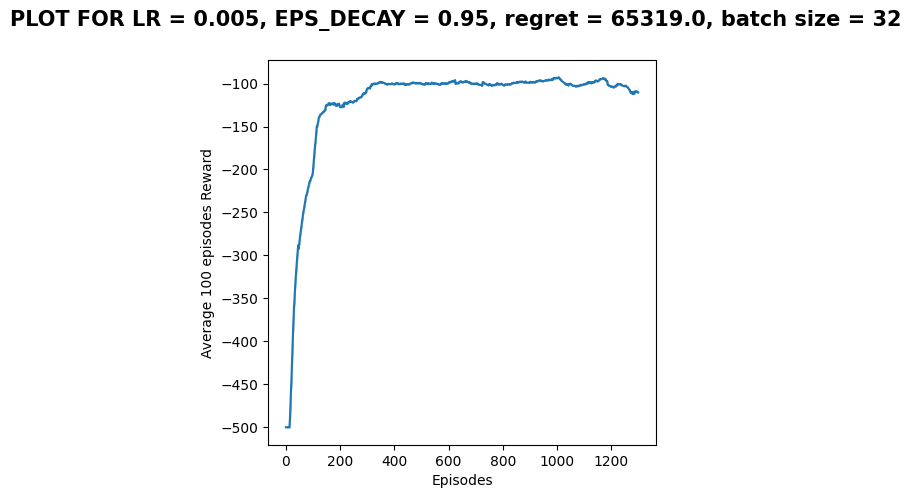

Learning Rate:0.005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -172.05
Episode 200	Average Score: -106.36
Episode 300	Average Score: -95.26
Episode 400	Average Score: -97.47
Episode 500	Average Score: -97.70
Episode 600	Average Score: -94.55
Episode 700	Average Score: -96.80
Episode 800	Average Score: -96.74
Episode 900	Average Score: -94.97
Episode 1000	Average Score: -92.53
Episode 1100	Average Score: -92.43
Episode 1200	Average Score: -94.77
Episode 1300	Average Score: -91.97


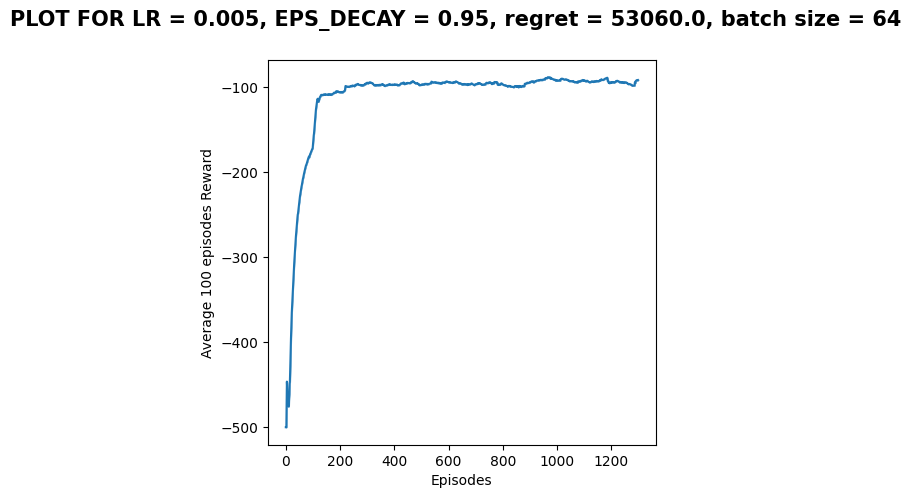

Learning Rate:0.005, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -154.33
Episode 200	Average Score: -110.24
Episode 300	Average Score: -106.94
Episode 400	Average Score: -100.24
Episode 500	Average Score: -108.82
Episode 600	Average Score: -100.84
Episode 700	Average Score: -99.75
Episode 800	Average Score: -96.48
Episode 900	Average Score: -96.90
Episode 1000	Average Score: -97.70
Episode 1100	Average Score: -112.21
Episode 1200	Average Score: -96.58
Episode 1300	Average Score: -106.07


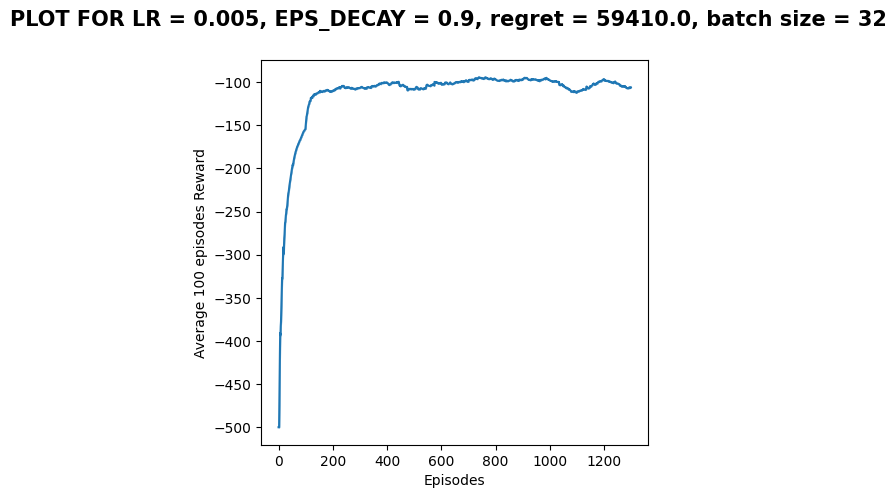

Learning Rate:0.005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -141.42
Episode 200	Average Score: -102.04
Episode 300	Average Score: -90.90
Episode 400	Average Score: -90.88
Episode 500	Average Score: -92.53
Episode 600	Average Score: -92.09
Episode 700	Average Score: -87.62
Episode 800	Average Score: -92.82
Episode 900	Average Score: -86.86
Episode 1000	Average Score: -86.55
Episode 1100	Average Score: -91.22
Episode 1200	Average Score: -92.59
Episode 1300	Average Score: -90.73


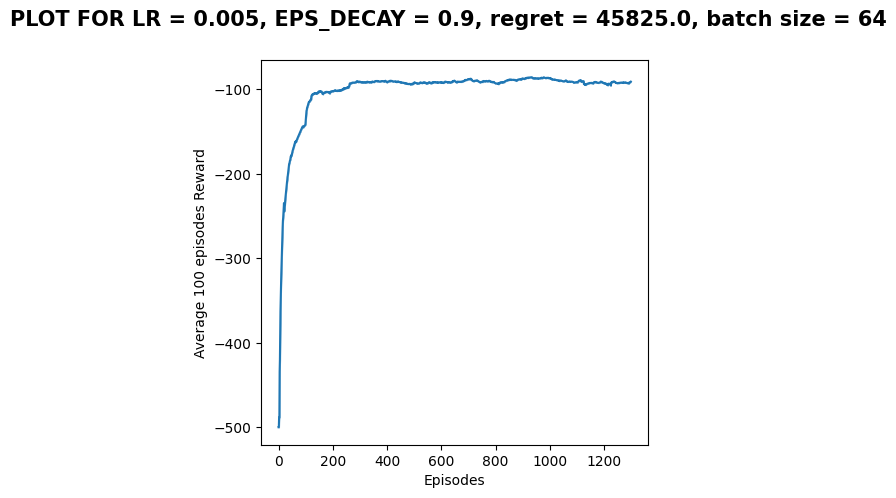

Learning Rate:0.005, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -176.89
Episode 200	Average Score: -120.22
Episode 300	Average Score: -113.71
Episode 400	Average Score: -102.32
Episode 500	Average Score: -101.84
Episode 600	Average Score: -106.14
Episode 700	Average Score: -101.25
Episode 800	Average Score: -106.71
Episode 900	Average Score: -105.48
Episode 1000	Average Score: -103.30
Episode 1100	Average Score: -104.14
Episode 1200	Average Score: -100.21
Episode 1300	Average Score: -94.86


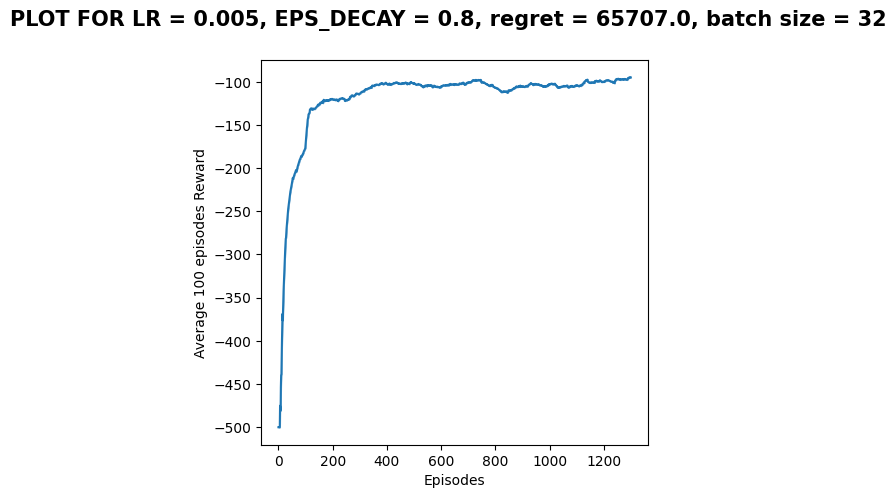

Learning Rate:0.005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -127.56
Episode 200	Average Score: -93.15
Episode 300	Average Score: -94.58
Episode 400	Average Score: -95.85
Episode 500	Average Score: -95.61
Episode 600	Average Score: -89.86
Episode 700	Average Score: -94.11
Episode 800	Average Score: -94.24
Episode 900	Average Score: -95.10
Episode 1000	Average Score: -95.58
Episode 1100	Average Score: -92.34
Episode 1200	Average Score: -91.35
Episode 1300	Average Score: -89.21


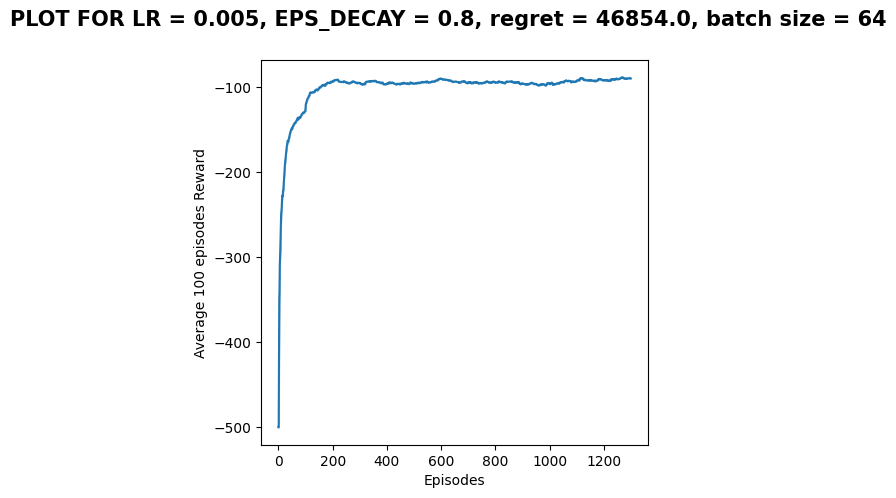

Learning Rate:0.0005, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -195.34
Episode 200	Average Score: -95.62
Episode 300	Average Score: -91.61
Episode 400	Average Score: -85.27
Episode 500	Average Score: -83.59
Episode 600	Average Score: -82.80
Episode 700	Average Score: -90.02
Episode 800	Average Score: -86.19
Episode 900	Average Score: -84.46
Episode 1000	Average Score: -89.10
Episode 1100	Average Score: -87.00
Episode 1200	Average Score: -93.89
Episode 1300	Average Score: -92.18


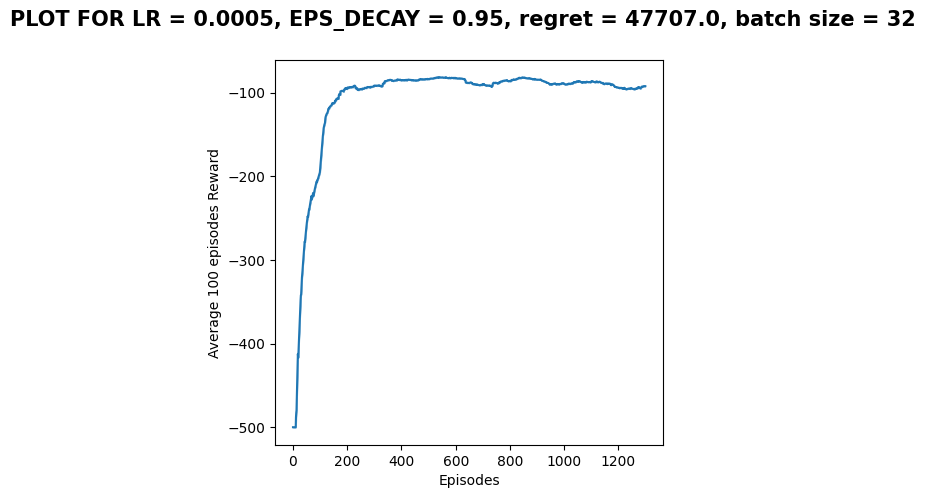

Learning Rate:0.0005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -163.55
Episode 200	Average Score: -90.04
Episode 300	Average Score: -92.07
Episode 400	Average Score: -88.16
Episode 500	Average Score: -90.73
Episode 600	Average Score: -84.19
Episode 700	Average Score: -85.89
Episode 800	Average Score: -93.16
Episode 900	Average Score: -85.59
Episode 1000	Average Score: -86.02
Episode 1100	Average Score: -85.15
Episode 1200	Average Score: -85.77
Episode 1300	Average Score: -92.83


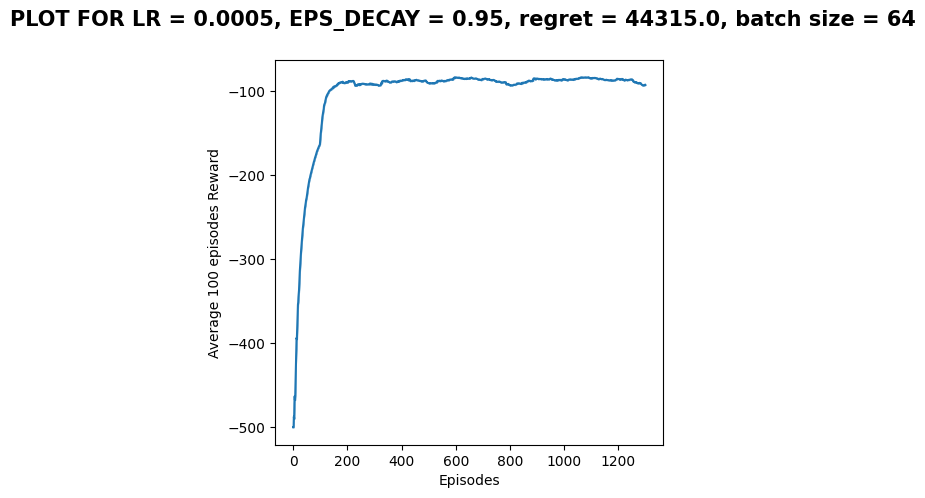

Learning Rate:0.0005, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -221.67
Episode 200	Average Score: -99.50
Episode 300	Average Score: -90.26
Episode 400	Average Score: -86.32
Episode 500	Average Score: -88.49
Episode 600	Average Score: -86.38
Episode 700	Average Score: -86.77
Episode 800	Average Score: -88.29
Episode 900	Average Score: -91.43
Episode 1000	Average Score: -85.28
Episode 1100	Average Score: -86.30
Episode 1200	Average Score: -86.69
Episode 1300	Average Score: -85.94


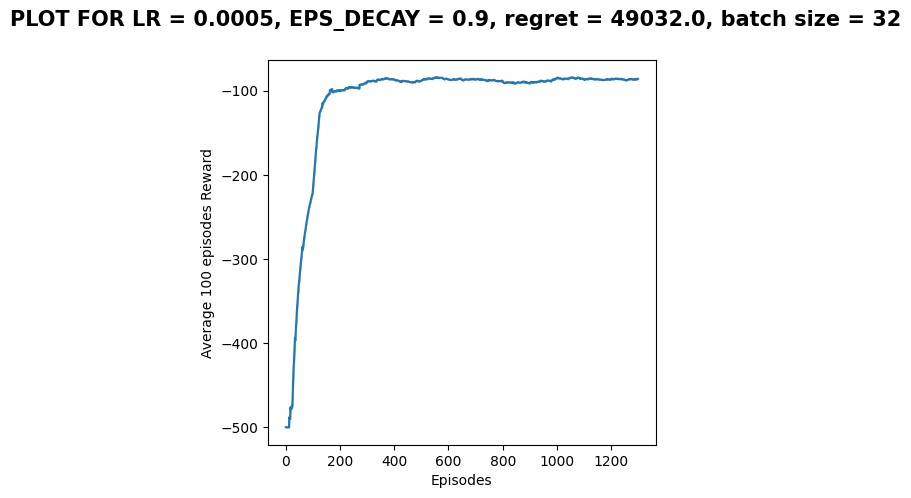

Learning Rate:0.0005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -144.36
Episode 200	Average Score: -93.67
Episode 300	Average Score: -85.49
Episode 400	Average Score: -91.23
Episode 500	Average Score: -88.37
Episode 600	Average Score: -86.26
Episode 700	Average Score: -88.05
Episode 800	Average Score: -85.62
Episode 900	Average Score: -79.85
Episode 1000	Average Score: -84.41
Episode 1100	Average Score: -86.24
Episode 1200	Average Score: -82.06
Episode 1300	Average Score: -83.65


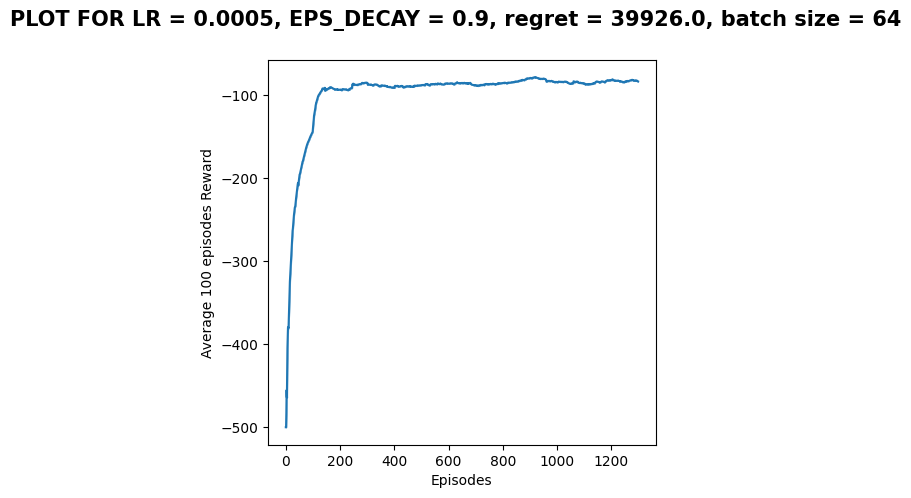

Learning Rate:0.0005, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -147.62
Episode 200	Average Score: -95.60
Episode 300	Average Score: -95.84
Episode 400	Average Score: -89.80
Episode 500	Average Score: -93.63
Episode 600	Average Score: -97.13
Episode 700	Average Score: -91.74
Episode 800	Average Score: -93.57
Episode 900	Average Score: -86.52
Episode 1000	Average Score: -90.22
Episode 1100	Average Score: -91.28
Episode 1200	Average Score: -88.03
Episode 1300	Average Score: -88.19


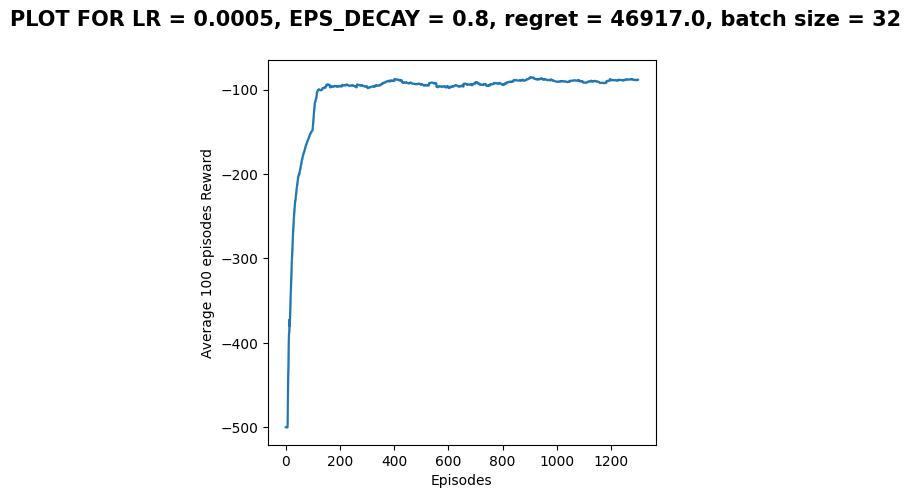

Learning Rate:0.0005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -129.90
Episode 200	Average Score: -91.46
Episode 300	Average Score: -89.77
Episode 400	Average Score: -84.67
Episode 500	Average Score: -88.21
Episode 600	Average Score: -88.63
Episode 700	Average Score: -88.56
Episode 800	Average Score: -85.89
Episode 900	Average Score: -92.28
Episode 1000	Average Score: -84.98
Episode 1100	Average Score: -88.54
Episode 1200	Average Score: -88.70
Episode 1300	Average Score: -83.10


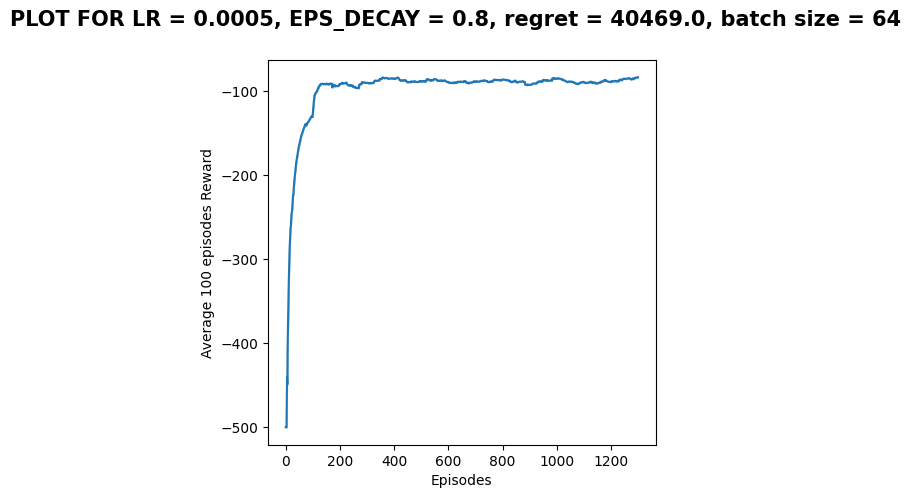

Learning Rate:5e-05, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -140.28
Episode 200	Average Score: -121.30
Episode 300	Average Score: -125.59
Episode 400	Average Score: -98.36
Episode 500	Average Score: -92.80
Episode 600	Average Score: -89.15
Episode 700	Average Score: -83.22
Episode 800	Average Score: -84.47
Episode 900	Average Score: -91.81
Episode 1000	Average Score: -83.88
Episode 1100	Average Score: -86.86
Episode 1200	Average Score: -87.29
Episode 1300	Average Score: -87.02


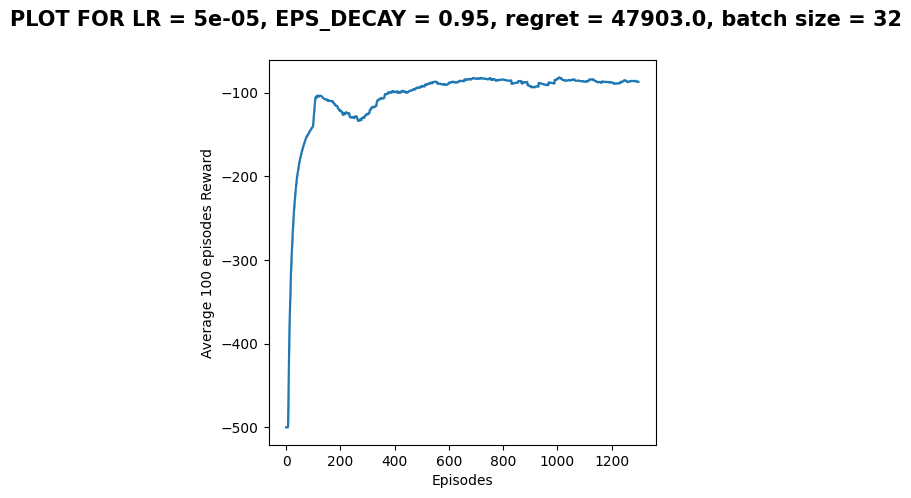

Learning Rate:5e-05, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -139.40
Episode 200	Average Score: -110.98
Episode 300	Average Score: -101.32
Episode 400	Average Score: -89.83
Episode 500	Average Score: -86.95
Episode 600	Average Score: -89.89
Episode 700	Average Score: -89.68
Episode 800	Average Score: -85.14
Episode 900	Average Score: -85.24
Episode 1000	Average Score: -84.41
Episode 1100	Average Score: -83.25
Episode 1200	Average Score: -85.45
Episode 1300	Average Score: -84.66


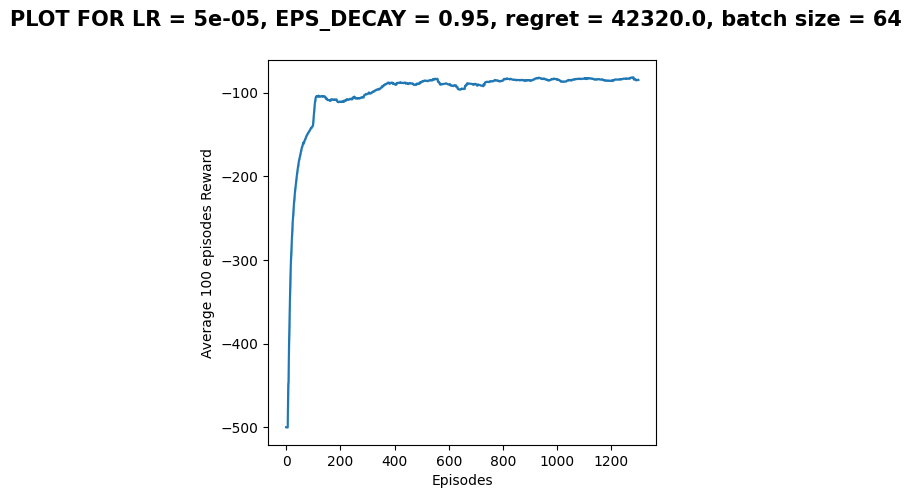

Learning Rate:5e-05, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -130.61
Episode 200	Average Score: -104.52
Episode 300	Average Score: -103.80
Episode 400	Average Score: -100.36
Episode 500	Average Score: -94.02
Episode 600	Average Score: -86.53
Episode 700	Average Score: -87.42
Episode 800	Average Score: -92.44
Episode 900	Average Score: -83.39
Episode 1000	Average Score: -86.70
Episode 1100	Average Score: -84.91
Episode 1200	Average Score: -82.19
Episode 1300	Average Score: -83.27


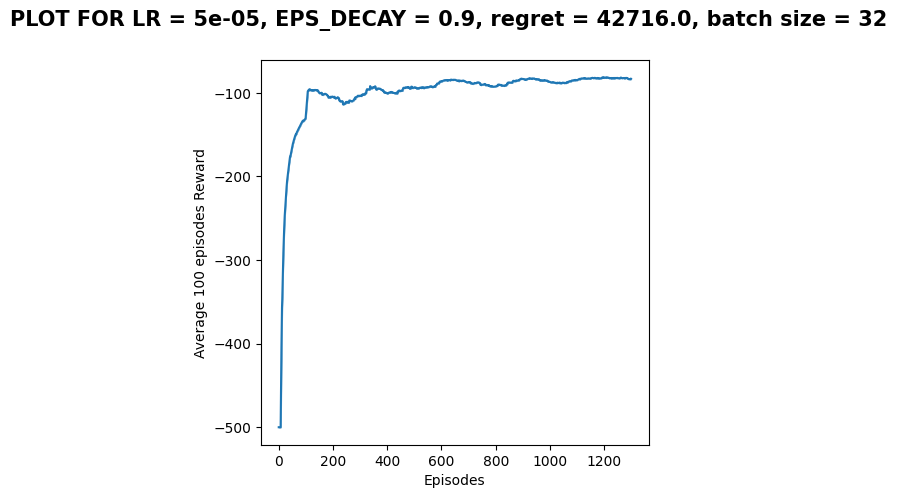

Learning Rate:5e-05, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -135.97
Episode 200	Average Score: -128.11
Episode 300	Average Score: -102.87
Episode 400	Average Score: -98.70
Episode 500	Average Score: -91.71
Episode 600	Average Score: -91.42
Episode 700	Average Score: -87.49
Episode 800	Average Score: -86.31
Episode 900	Average Score: -84.57
Episode 1000	Average Score: -86.84
Episode 1100	Average Score: -90.22
Episode 1200	Average Score: -84.09
Episode 1300	Average Score: -89.08


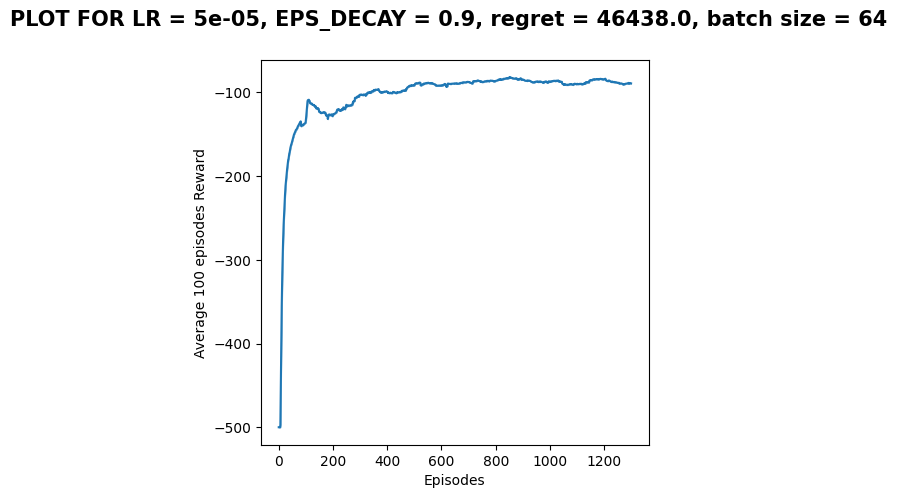

Learning Rate:5e-05, BATCH_SIZE: 32, UPDATE_EVERY : 20
Episode 100	Average Score: -142.30
Episode 200	Average Score: -107.84
Episode 300	Average Score: -109.20
Episode 400	Average Score: -102.44
Episode 500	Average Score: -92.44
Episode 600	Average Score: -92.37
Episode 700	Average Score: -86.32
Episode 800	Average Score: -84.20
Episode 900	Average Score: -82.87
Episode 1000	Average Score: -84.42
Episode 1100	Average Score: -85.68
Episode 1200	Average Score: -89.05
Episode 1300	Average Score: -90.76


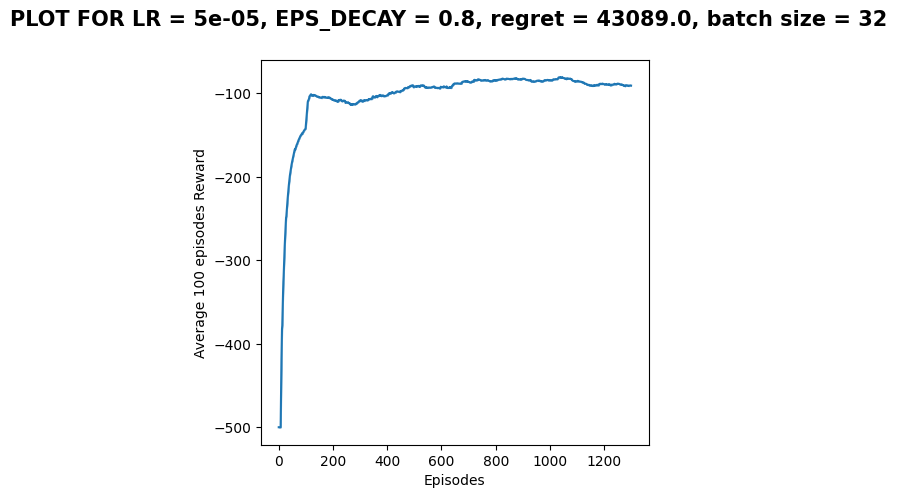

Learning Rate:5e-05, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -153.02
Episode 200	Average Score: -112.87
Episode 300	Average Score: -98.71
Episode 400	Average Score: -87.56
Episode 500	Average Score: -88.47
Episode 600	Average Score: -85.03
Episode 700	Average Score: -87.82
Episode 800	Average Score: -84.22
Episode 900	Average Score: -83.76
Episode 1000	Average Score: -85.72
Episode 1100	Average Score: -84.92
Episode 1200	Average Score: -85.02
Episode 1300	Average Score: -83.91


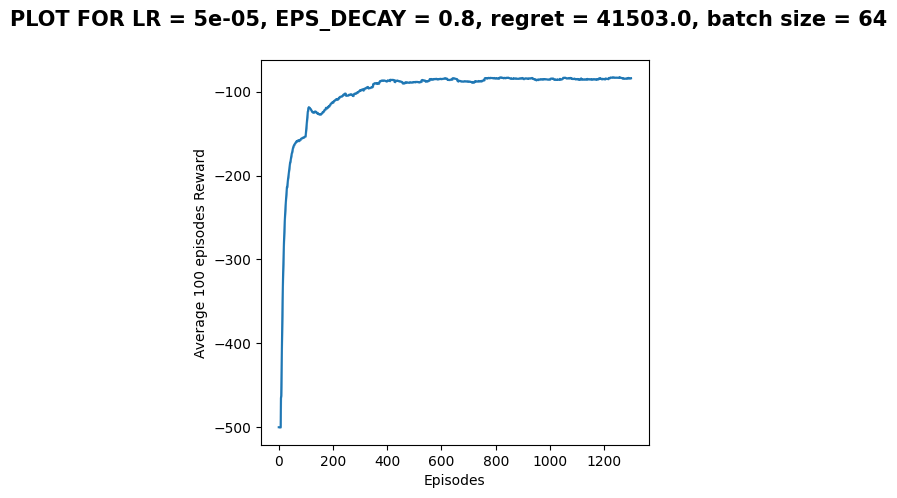

In [24]:
lrs = [5e-3, 5e-4, 5e-5]
eps_decays = [0.95, 0.9, 0.8] # 0.95 -> 135 episodes expolaration higher than 0.001, 60 ,30
batch = [32 , 64]
seed = 0
for LR in lrs:
  for eps_decay in eps_decays:
    for BATCH_SIZE in batch:
      agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
      avg_r , eps_r = dqn(eps_decay = eps_decay)
      reg = regret([eps_r])
      plot_f([avg_r], f'PLOT FOR LR = {LR}, EPS_DECAY = {eps_decay}, regret = {reg[0]}, batch size = {BATCH_SIZE}')


##From the above graphs we can see that for learning rate of 5e-4 , epsilon decay of 0.9 and batch size of 64 we get the minimum regret, for all the different parameters tried above.


In [70]:
#It was found out that for epsilon set to values of 0.1 the curve reached a peak and fell down again to the bottom and this happended multiple times when run for 3000 episodes
#Hence epsilon was set very small.
#For learning rate greater than 10^-4 the graphs looked something like this

# 5 random seed Runs with tuned hyper parameter both type 1 and type 2

In [73]:
#Tuned Hyperparameters
LR = 5e-4
BATCH_SIZE = 64
eps_decay = 0.9
seeds = [32, 56, 2, 9 ,7 ]
r = [[],[]]

In [74]:
for t in range(1,3):
  for i in range(5):
    env = gym.make('Acrobot-v1')
    env.seed(seeds[i])
    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    agent = TutorialAgent(typ = t, state_size=state_shape,action_size = action_shape,seed = 0)
    avg_r , _ = dqn(n_episodes=1500, eps_decay= eps_decay)
    r[t-1].append(avg_r)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Learning Rate:0.0005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -142.98
Episode 200	Average Score: -89.35
Episode 300	Average Score: -85.19
Episode 400	Average Score: -88.45
Episode 500	Average Score: -86.31
Episode 600	Average Score: -88.39
Episode 700	Average Score: -91.22
Episode 800	Average Score: -86.20
Episode 900	Average Score: -90.59
Episode 1000	Average Score: -86.91
Episode 1100	Average Score: -84.80
Episode 1200	Average Score: -83.06
Episode 1300	Average Score: -85.02
Episode 1400	Average Score: -84.19
Episode 1500	Average Score: -83.42
Learning Rate:0.0005, BATCH_SIZE: 64, UPDATE_EVERY : 20
Episode 100	Average Score: -130.01
Episode 200	Average Score: -90.77
Episode 300	Average Score: -96.03
Episode 400	Average Score: -88.18
Episode 500	Average Score: -87.37
Episode 600	Average Score: -89.45
Episode 700	Average Score: -91.88
Episode 800	Average Score: -88.23
Episode 900	Average Score: -90.43
Episode 1000	Average Score: -95.03
Episode 1100	Average Score: -

In [80]:
print(r[0])
print(r[1])

[[-500.0, -500.0, -469.6666666666667, -429.5, -381.0, -384.5, -368.2857142857143, -377.125, -380.44444444444446, -368.6, -365.1818181818182, -354.75, -338.61538461538464, -326.7857142857143, -320.4, -315.8125, -308.2352941176471, -303.44444444444446, -296.57894736842104, -291.05, -283.5238095238095, -279.1818181818182, -273.4782608695652, -264.9583333333333, -259.28, -253.96153846153845, -248.4814814814815, -243.17857142857142, -237.6551724137931, -232.73333333333332, -228.2258064516129, -224.6875, -221.0909090909091, -217.2941176470588, -213.54285714285714, -209.97222222222223, -206.97297297297297, -203.8421052631579, -201.84615384615384, -198.55, -195.82926829268294, -194.1904761904762, -192.13953488372093, -189.4090909090909, -186.95555555555555, -185.8913043478261, -184.2127659574468, -182.35416666666666, -181.12244897959184, -180.76, -179.2156862745098, -177.3846153846154, -175.83018867924528, -174.2037037037037, -173.43636363636364, -173.66071428571428, -175.21052631578948, -174.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Plotting Both type one and type two on same plot:

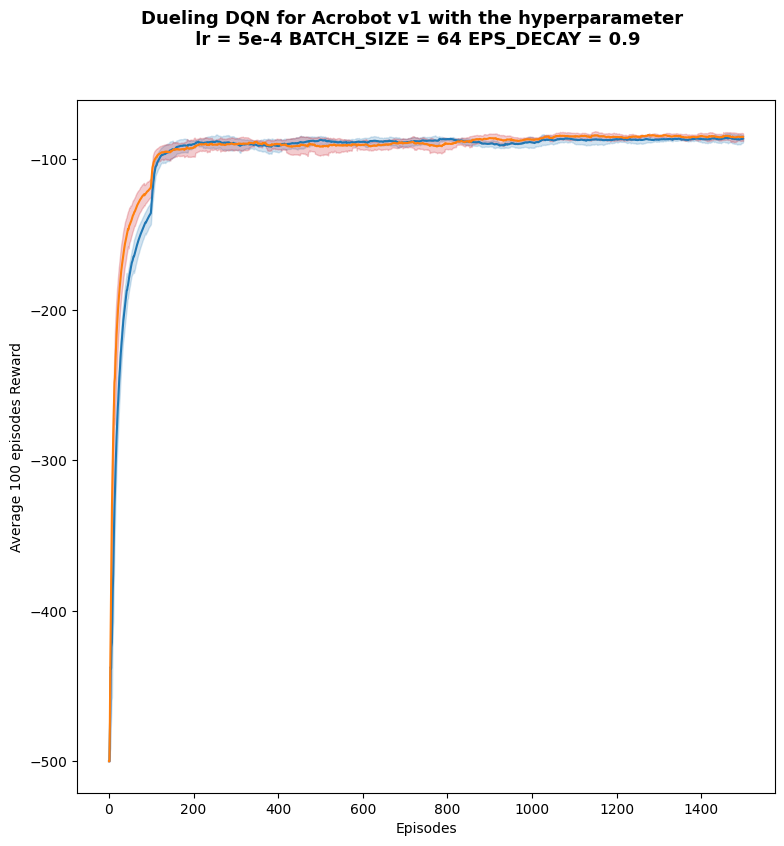

In [79]:
msg = f'Dueling DQN for Acrobot v1 with the hyperparameter \n lr = 5e-4 BATCH_SIZE = 64 EPS_DECAY = 0.9'
fig, ax = plt.subplots(figsize=(9, 9))
#plt.figure(figsize=(15,15))
fig.suptitle(msg ,fontsize=13,weight = 'extra bold')
mean_y = np.mean(r[0],0)
std_y = np.std(r[0],0)
ax.plot( range(0,len(r[0][0])), np.average(r[0],0) ,label = 'Type 1')
ax.fill_between(range(0,len(r[0][0])), mean_y - std_y, mean_y + std_y, color='#1f77b4', alpha=0.2)

mean_y = np.mean(r[1],0)
std_y = np.std(r[1],0)
ax.plot( range(0,len(r[1][0])), np.average(r[1],0) , label = 'Type 2' )
ax.fill_between(range(0,len(r[1][0])), mean_y - std_y, mean_y + std_y, color='#c30010', alpha=0.2)

ax.set_xlabel('Episodes')
ax.set_ylabel('Average 100 episodes Reward')
plt.show()
